# <font color='lightblue'>Used Car Price Prediction Analysis</font>

# <font color='yellow'>Question</font>

How well can the selling price of a used car be predicted with the given dataset?

## <font color='lightgreen'>Process</font>

* Read in data
* Drop duplicates and observe what missing values need to be addressed
* Remove NaN rows from target variable, then from all other rows except transmission
* Group data to find most likely value for transmission based on other car data
* Clean date column to be a datetime, and create month/year/day columns
* Scale continuous data
* Explore data with graphs
* Find which categorical columns to encode, seeing how much each column will increase the dimensionality
* Cross-validate model
* Train final model
* Identify and plot feature importances

## <font color='pink'>Problem areas</font>:

Not all columns were used, so there could possibly be some areas where more careful and meticulous feature selection could have been beneficial.

No hyperparameter tuning, so the model may have been even better if the hyperparameters of the XGBoost model were more tuned.

The column "mmr" makes up almost the entirety of the predictive weight of the model, which is a bit concerning overall. This is not something inherently bad, but the model is not terribly robust as a result, and likely has lots of error if the mmr does not reflect the sale price closely.

## MAE - 0.004051484311672436

In [1]:
#imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import kaggle

warnings.filterwarnings('ignore')

In [2]:
#read in data

kaggle.api.authenticate()
kaggle.api.dataset_download_files('syedanwarafridi/vehicle-sales-data', path='../data', unzip=True)
data = pd.read_csv('../data/car_prices.csv')
data.head()

Dataset URL: https://www.kaggle.com/datasets/syedanwarafridi/vehicle-sales-data


,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,mmr,sellingprice,saledate
0,2015,Kia,Sorento,LX,SUV,automatic,5xyktca69fg566472,ca,5.0,16639.0,white,black,kia motors america inc,20500.0,21500.0,Tue Dec 16 2014 12:30:00 GMT-0800 (PST)
1,2015,Kia,Sorento,LX,SUV,automatic,5xyktca69fg561319,ca,5.0,9393.0,white,beige,kia motors america inc,20800.0,21500.0,Tue Dec 16 2014 12:30:00 GMT-0800 (PST)
2,2014,BMW,3 Series,328i SULEV,Sedan,automatic,wba3c1c51ek116351,ca,45.0,1331.0,gray,black,financial services remarketing (lease),31900.0,30000.0,Thu Jan 15 2015 04:30:00 GMT-0800 (PST)
3,2015,Volvo,S60,T5,Sedan,automatic,yv1612tb4f1310987,ca,41.0,14282.0,white,black,volvo na rep/world omni,27500.0,27750.0,Thu Jan 29 2015 04:30:00 GMT-0800 (PST)
4,2014,BMW,6 Series Gran Coupe,650i,Sedan,automatic,wba6b2c57ed129731,ca,43.0,2641.0,gray,black,financial services remarketing (lease),66000.0,67000.0,Thu Dec 18 2014 12:30:00 GMT-0800 (PST)


In [3]:
#drop duplicates, then check for null values and observe dtypes

data = data.drop_duplicates()
data.info()

#objects - make, model, trim, body, transmission, vin, color, interior, seller, saledate
#floats - condition, odometer, mmr, sellingprice

<class 'pandas.core.frame.DataFrame'>
Int64Index: 558837 entries, 0 to 558836
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   year          558837 non-null  int64  
 1   make          548536 non-null  object 
 2   model         548438 non-null  object 
 3   trim          548186 non-null  object 
 4   body          545642 non-null  object 
 5   transmission  493485 non-null  object 
 6   vin           558833 non-null  object 
 7   state         558837 non-null  object 
 8   condition     547017 non-null  float64
 9   odometer      558743 non-null  float64
 10  color         558088 non-null  object 
 11  interior      558088 non-null  object 
 12  seller        558837 non-null  object 
 13  mmr           558799 non-null  float64
 14  sellingprice  558825 non-null  float64
 15  saledate      558825 non-null  object 
dtypes: float64(4), int64(1), object(11)
memory usage: 72.5+ MB


In [4]:
#sellingprice is the target variable, so any without a sellingprice should be removed

data = data[~data['sellingprice'].isna()]

In [5]:
#removing all NaN values, as imputing them with the mode may lead to incorrect values

cols = list(data.columns)
cols.remove('transmission')
data = data.dropna(subset=cols)
data.shape

(533648, 16)

In [ ]:
#A possible alternative to removing NaN values outright is to replace them with "unknown"

In [6]:
car_cols = ['year', 'model', 'make', 'transmission']

transmission_data = data.groupby(car_cols)['transmission'].count()

In [7]:
#replace transmission with most common transmission for car type

rows_to_drop = []
for i, row in data.iterrows():
    if pd.isna(row['transmission']):
        try:
            data.at[i, 'transmission'] = transmission_data[(row['year'], row['model'], row['make'])].index[0]
        except KeyError:
            rows_to_drop.append(i)

# Remove rows with one model where no transmission data was present
if rows_to_drop:
    data.drop(rows_to_drop, inplace=True)

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 533605 entries, 0 to 558836
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   year          533605 non-null  int64  
 1   make          533605 non-null  object 
 2   model         533605 non-null  object 
 3   trim          533605 non-null  object 
 4   body          533605 non-null  object 
 5   transmission  533605 non-null  object 
 6   vin           533605 non-null  object 
 7   state         533605 non-null  object 
 8   condition     533605 non-null  float64
 9   odometer      533605 non-null  float64
 10  color         533605 non-null  object 
 11  interior      533605 non-null  object 
 12  seller        533605 non-null  object 
 13  mmr           533605 non-null  float64
 14  sellingprice  533605 non-null  float64
 15  saledate      533605 non-null  object 
dtypes: float64(4), int64(1), object(11)
memory usage: 69.2+ MB


In [8]:
#change saledate to datetime, add sale day, month, year cols

data['saledate'] = pd.to_datetime(data['saledate'].str[3:15])
data['saleyear'], data['salemonth'], data['saleday'] = data['saledate'].dt.year, data['saledate'].dt.month, data['saledate'].dt.day

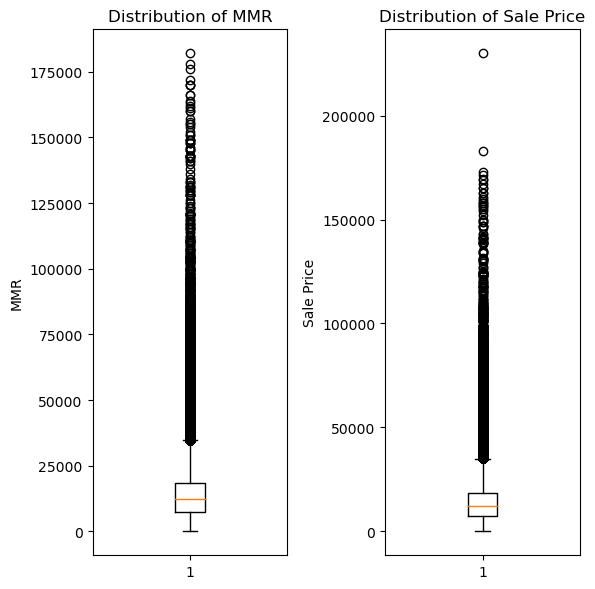

In [30]:
#plot of mmr and sellingprice distributions

fig, ax = plt.subplots(1, 2, figsize=(6,6))
ax[0].boxplot(data=data, x='mmr')
ax[0].set_title('Distribution of MMR')
ax[0].set_ylabel('MMR')
ax[1].boxplot(data=data, x='sellingprice')
ax[1].set_title('Distribution of Sale Price')
ax[1].set_ylabel('Sale Price')
plt.tight_layout()

#both of these have extremely similar distributions

Text(0, 0.5, 'Sale Price')

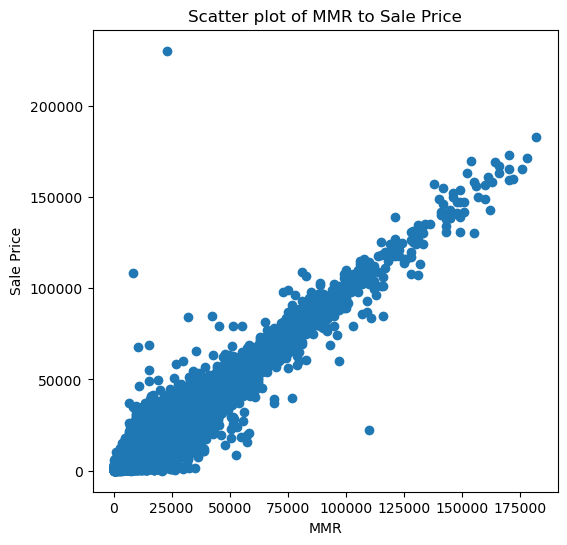

In [38]:
#scatter plot of mmr vs selling price

fig, ax = plt.subplots(figsize=(6,6))
ax.scatter(data['mmr'], data['sellingprice'])
ax.set_title('Scatter plot of MMR to Sale Price')
ax.set_xlabel('MMR')
ax.set_ylabel('Sale Price')

#these two are largely related it would seem based on this distribution

In [219]:
#get numeric features and scale
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
numeric_cols = ['year', 'condition', 'odometer', 'saleyear', 'salemonth', 'saleday', 'sellingprice', 'mmr']

data[numeric_cols] = scaler.fit_transform(data[numeric_cols])

In [220]:
#encode categorical columns

categorical_cols = ['make', 'model', 'trim', 'body', 'transmission', 'state', 'color', 'interior', 'seller']

for col in categorical_cols:
    print(f'Column: {col}, num unique: {len(data[col].unique())}')

#trim, seller will increase dimensionality by far too much. model will still be kept, as it is likely hugely important

categorical_cols_final = ['make', 'body', 'transmission', 'state', 'color', 'interior']

data = pd.get_dummies(data, columns=categorical_cols_final, drop_first=True)

Column: make, num unique: 53
Column: model, num unique: 768
Column: trim, num unique: 1507
Column: body, num unique: 86
Column: transmission, num unique: 2
Column: state, num unique: 38
Column: color, num unique: 20
Column: interior, num unique: 17
Column: seller, num unique: 12733


In [221]:
#split data into train/test

from sklearn.model_selection import train_test_split

X = data.drop(['vin', 'saledate', 'trim', 'seller', 'sellingprice', 'model', 'sellingprice'], axis=1)
y = data['sellingprice']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=8)

In [222]:
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

cross_val_score(XGBRegressor(seed=8), X_train, y_train, cv=5, scoring='neg_mean_absolute_error', verbose=False).mean()

#this cross val score is higher than expected, but the data is likely far too dimensional

-0.004046560476162379

In [223]:
#create new model to evaluate feature importances

boost = XGBRegressor(seed=8)
boost.fit(X_train, y_train)

y_pred = boost.predict(X_test)

mean_absolute_error(y_test, y_pred)

0.004051484311672436

Text(0.5, 1.0, 'Feature Importances (1-20)')

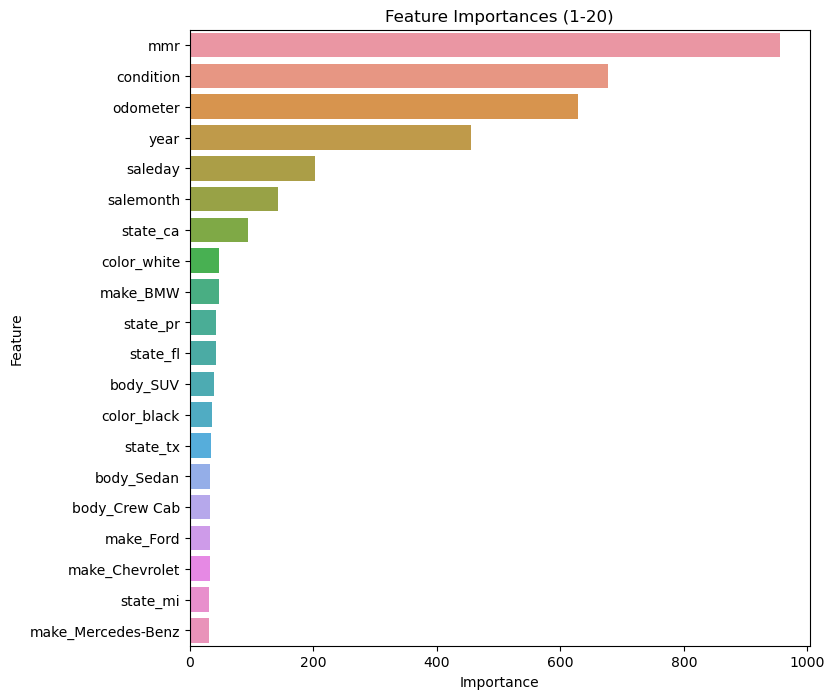

In [224]:
#plot feature importances
import matplotlib.pyplot as plt
import seaborn as sns

feat_importances = pd.DataFrame(boost.get_booster().get_fscore().items(), columns=['Feature', 'Importance']).sort_values('Importance', ascending=False)

fig, ax = plt.subplots(figsize=(8,8))
sns.barplot(data=feat_importances.iloc[:20], x='Importance', y='Feature', orient='h')
ax.set_title('Feature Importances (1-20)')